In [1]:
include("models/ppl/main.jl")

In [2]:
using CairoMakie


In [3]:
struct TSType
    # policies::Dict{Int, Vector{Policy}}
    mean_rewards::Dict{Int, Float64}
    name::String
    info::Dict
end

In [65]:
using JSON3
using Serialization

function load_ts_from_json(file_path::String)::TSType
    json_data = JSON3.read(file_path)
    mean_rewards = Dict{Int, Float64}(
        parse(Int, string(k)) => Float64(v) for (k, v) in json_data["mean_rewards"]
    )
    name = json_data["info"]["name"]
    # info = Dict(json_data["info"])
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return TSType(mean_rewards, name, info)
end

load_ts_from_json (generic function with 1 method)

In [5]:
using PyCall
sepsis_gym = pyimport("custom_sepsis")

ts = sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-0.json")

PyObject <custom_sepsis.models.dirichlet.evaluate.thompson_sampling.DirThompsonSampling object at 0x127eb3a00>

In [62]:
using JSON3

function save_ts_to_json(ts_instance::TSType, file_path::String)
    json_data = Dict(
        "mean_rewards" => ts_instance.mean_rewards,
        "name" => ts_instance.name,
        "info" => ts_instance.info
    )
    JSON3.write(file_path, json_data)
end


save_ts_to_json (generic function with 1 method)

In [ ]:
dqn = load_ts_from_json("json/dqn/ts/DQN-0.json")

"json/dqn/ts/DQN-0.json"

In [193]:
ts = Dict(
    :Simple => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-$i.json") for i in 0:2],
    :Medium => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Medium-$i.json") for i in 0:2],
    :None => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/None-$i.json") for i in 0:2],
    :DQN => [load_ts_from_json("json/dqn/ts/DQN-$i.json") for i in 0:2],
    :Softmax => [load_jld("data/mcmc/ts/softmax.jld"), 
                load_jld("data/mcmc/ts/softmax-1.jld"), 
                load_jld("data/mcmc/ts/softmax-2.jld"), ]
)

Dict{Symbol, Vector} with 5 entries:
  :Softmax => PPTSRun[PPTSRun("softmax", MCMCModel(:softmax, DynamicChoiceMap(D…
  :None    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thomps…
  :Medium  => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thomps…
  :DQN     => TSType[TSType(Dict(200=>-0.61762, 16=>-0.84724, 4700=>-0.41784, 5…
  :Simple  => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thomps…

In [ ]:
using Statistics
random_mean = mean([sepsis_gym.evaluate_policy(sepsis_gym.random_policy(), 1000) for i in 1:100])

In [197]:
function plot_mean_rewards(ts)
    fig = Figure(resolution=(700, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size 100")

    colors = [:blue, :red, :green, :orange, :purple]
    window_size = 6  # Adjust the window size as needed

    # Data storage for accessing smoothed values later
    smoothed_data = Dict()

    ks = []
    for (i, type) in enumerate(keys(ts))
        all_keys = [sort(collect(keys(model.mean_rewards))) for model in ts[type]]
        min_keys = minimum(length.(all_keys))
        ks = all_keys[1][1:min_keys]
        all_rewards = []
        for model in ts[type]
            rewards = [model.mean_rewards[k] for k in ks]
            push!(all_rewards, rewards)
            lines!(ax, Float64.(ks), Float64.(rewards), color=(colors[i], 0.2))
        end
        mean_rewards = mean(all_rewards)
        smoothed_mean_rewards = moving_average(mean_rewards, window_size)
        lines!(ax, Float64.(ks), Float64.(smoothed_mean_rewards), color=colors[i], linewidth=1.5, label=string(type))

        std_rewards = std(all_rewards)
        smoothed_std_rewards = moving_average(std_rewards, window_size)
        low = smoothed_mean_rewards .- smoothed_std_rewards
        high = smoothed_mean_rewards .+ smoothed_std_rewards
        band!(ax, Float64.(ks), Float64.(low), Float64.(high), color=(colors[i], 0.2))

        # Save smoothed data for future use
        smoothed_data[type] = (ks=ks, smoothed_mean_rewards=smoothed_mean_rewards, smoothed_std_rewards=smoothed_std_rewards)
    end

    lines!(ax, ks, fill(random_mean, length(ks)), color=:black, linestyle=:dash, label="Random Policy")
    axislegend(ax)
    save("mean_rewards.png", fig)
    display(fig)

    return smoothed_data
end


plot_mean_rewards (generic function with 1 method)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


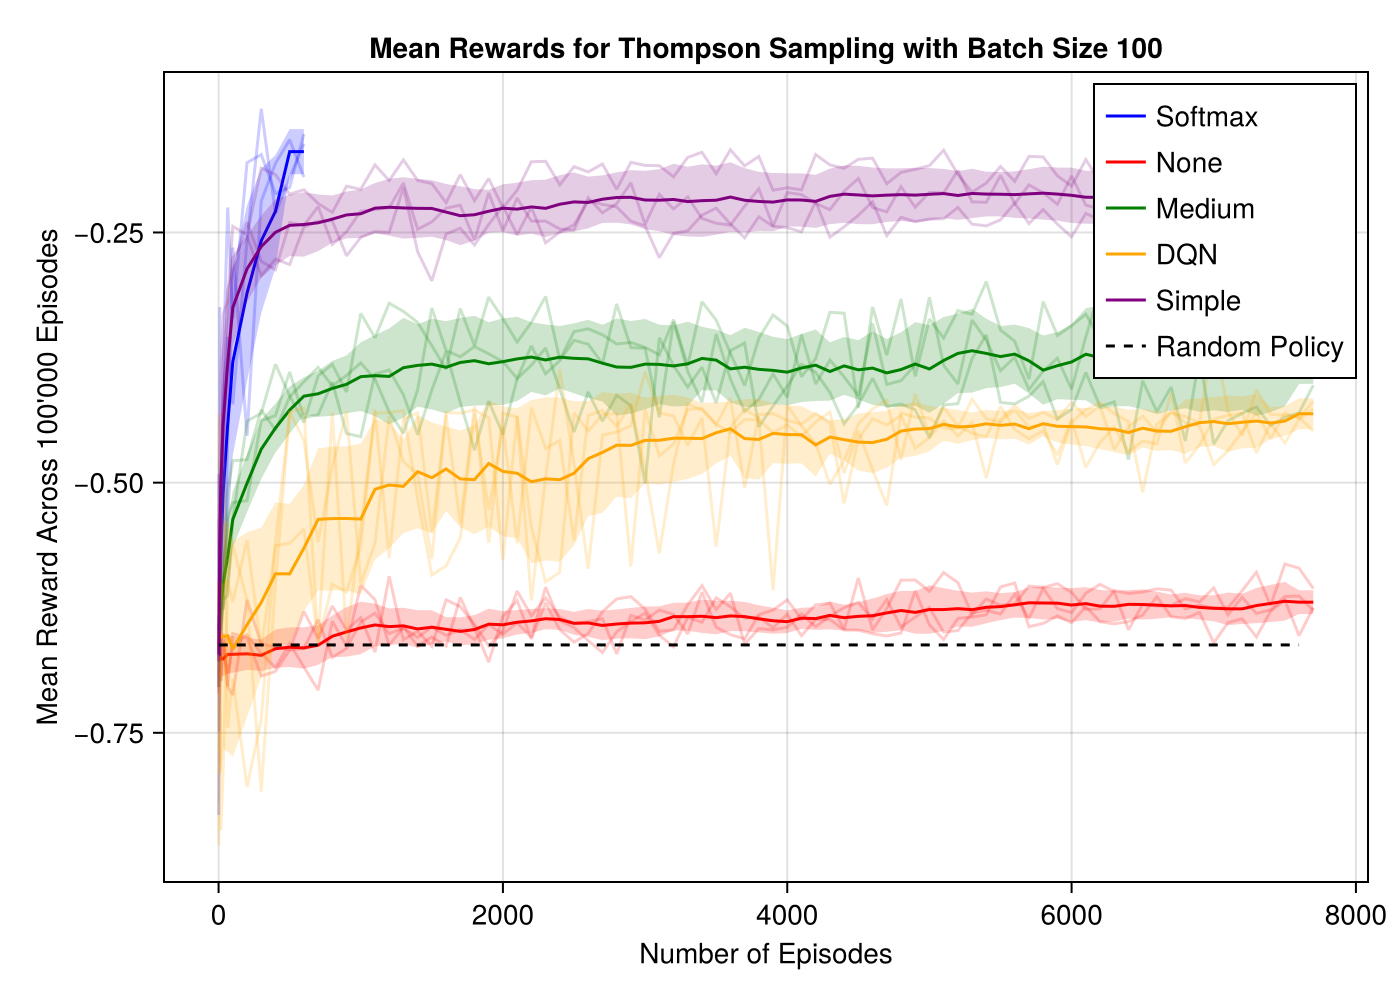

Dict{Any, Any} with 5 entries:
  :Softmax => (ks = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500, 600], smo…
  :None    => (ks = Any[1, 2, 4, 8, 16, 32, 64, 100, 200, 300  …  6800, 6900, 7…
  :Medium  => (ks = Any[1, 2, 4, 8, 16, 32, 64, 100, 200, 300  …  6800, 6900, 7…
  :DQN     => (ks = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300  …  6800, 6900, 7000…
  :Simple  => (ks = Any[1, 2, 4, 8, 16, 32, 64, 100, 200, 300  …  6700, 6800, 6…

In [198]:
smoothed = plot_mean_rewards(ts)

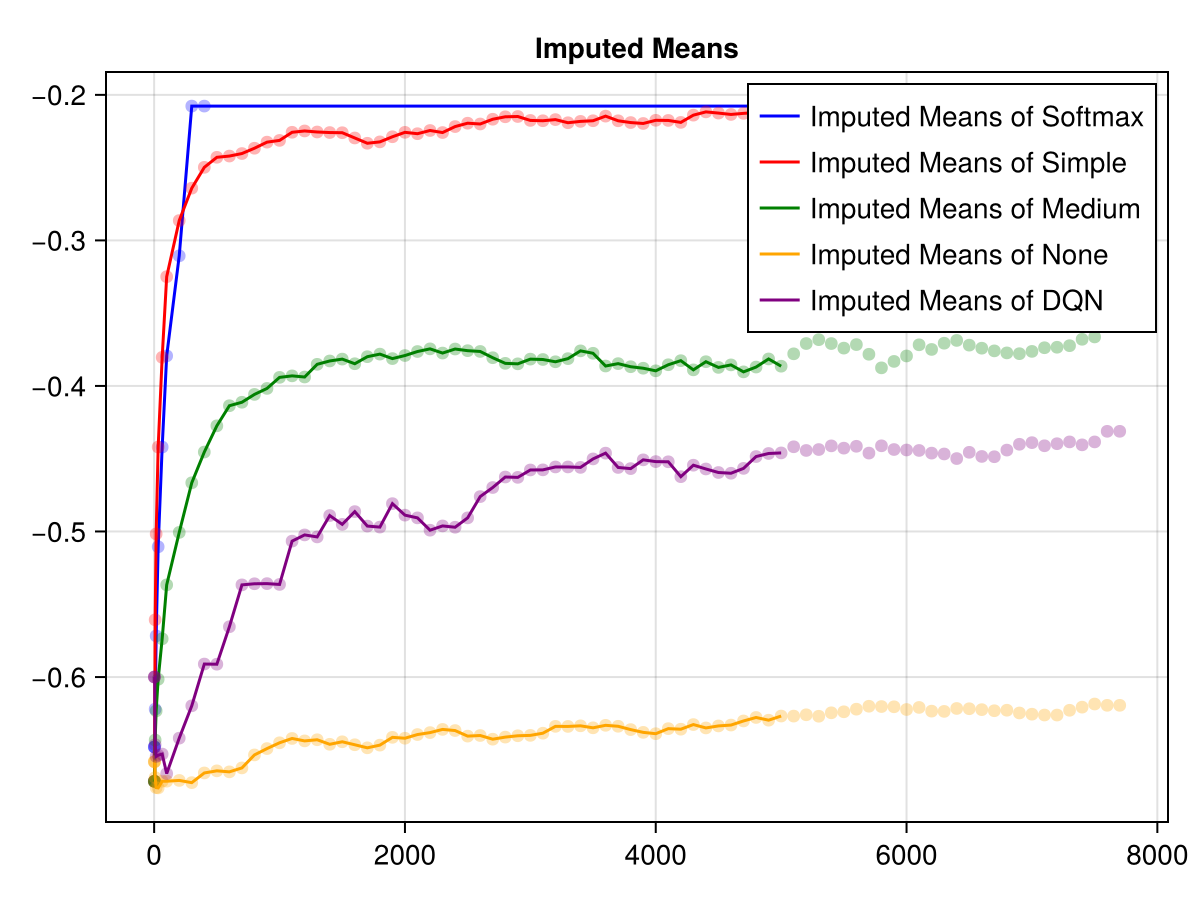

\begin{tabular}{|l|c|c|c|c|c|}
\hline
 & $1$ & $50$ & $100$ & $1000$ & $5000$ \\ \hline
Softmax & $-0.648$ & $-27.32$ & $-48.454$ & $-254.191$ & $-1085.098$ \\
Simple & $-0.672$ & $-24.461$ & $-42.628$ & $-269.871$ & $-1150.509$ \\
Medium & $-0.672$ & $-30.824$ & $-58.904$ & $-452.604$ & $-1984.947$ \\
None & $-0.658$ & $-33.641$ & $-67.233$ & $-663.474$ & $-3215.941$ \\
DQN & $-0.6$ & $-32.353$ & $-65.25$ & $-587.104$ & $-2474.427$ \\
\hline
\end{tabular}


In [191]:
using CairoMakie
using Interpolations

# Define the range for which data is needed
target_range = 1:5000

# Initialize a dictionary to store the values for the LaTeX table
latex_data = Dict(:Simple => [], :Medium => [], :None => [], :DQN => [], :Softmax => [])

# Define checkpoints
checkpoints = [1, 50, 100, 1000, 5000]

# Plot the original and imputed means
fig = Figure()
ax = Axis(fig[1, 1], title = "Imputed Means")
colors = [:blue, :red, :green, :orange, :purple]

for (i, type) in enumerate([:Softmax, :Simple, :Medium, :None, :DQN])
    # Extract the data for the current type
    ks, means, std = smoothed[type]

    # Create an interpolation function for means
    mean_interp = LinearInterpolation(ks, means, extrapolation_bc=Line())

    # Generate interpolated values for the entire target range
    imputed_means = [mean_interp(k) for k in target_range]

    sums = accumulate(+, imputed_means)

    # Store sums at each checkpoint for the LaTeX table
    latex_data[type] = [round(sums[checkpoint], digits=3) for checkpoint in checkpoints]

    # Plot original points
    scatter!(ax, ks, means, color = (colors[i], 0.3))

    # Plot interpolated values
    lines!(ax, target_range, imputed_means, label = "Imputed Means of $type", color = colors[i])
end

# Add legend
axislegend(ax)
display(fig)

# Generate the LaTeX table
println("\\begin{tabular}{|l|" * "c|"^(length(checkpoints)) * "}")
println("\\hline")
println(" & $(join(["\$" * string(c) * "\$" for c in checkpoints], " & ")) \\\\ \\hline")

for type in [:Softmax, :Simple, :Medium, :None, :DQN]
    row = "$(type) & $(join(["\$" * string(v) * "\$" for v in latex_data[type]], " & ")) \\\\"
    println(row)
end

println("\\hline")
println("\\end{tabular}")